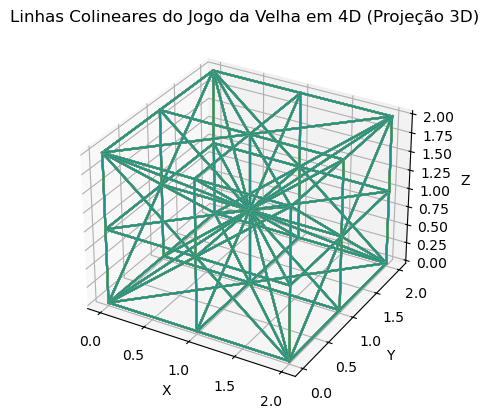

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import itertools
import numpy as np

# Definindo o tamanho da grade 4D (por exemplo, 3 para simplificação)
tamanho = 3

# Gerando todas as possíveis coordenadas 4D
coordenadas = list(itertools.product(range(tamanho), repeat=4))

# Função para verificar se três pontos são colineares em 4D
def colinear(p1, p2, p3):
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)
    return np.all(v1 * v2 == v1[0]*v2[0])  # Simplificação para vetores paralelos

# Coletando todas as linhas colineares
linhas = []
for comb in itertools.combinations(coordenadas, 4):
    # Verifica se todos os pontos na combinação são colineares
    v1 = np.array(comb[1]) - np.array(comb[0])
    v2 = np.array(comb[2]) - np.array(comb[0])
    v3 = np.array(comb[3]) - np.array(comb[0])
    # Verifica se os vetores são múltiplos entre si
    if np.all(v1 * v2 == v1[0] * v2[0]) and np.all(v1 * v3 == v1[0] * v3[0]):
        linhas.append(comb)

# Simplificação: considerar apenas linhas regulares (incremento constante)
linhas = []
direcoes = list(itertools.product([-1, 0, 1], repeat=4))
direcoes = [d for d in direcoes if any(c != 0 for c in d)]
for d in direcoes:
    for start in coordenadas:
        linha = [tuple(start[i] + d[i]*n for i in range(4)) for n in range(tamanho)]
        if all(0 <= coord < tamanho for coord in itertools.chain.from_iterable(linha)):
            linhas.append(linha)

# Remover duplicatas
linhas_unicas = []
for linha in linhas:
    if linha not in linhas_unicas:
        linhas_unicas.append(linha)

# Plotando a projeção 3D (ignorar a quarta dimensão ou representar com cor)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for linha in linhas_unicas:
    x = [p[0] for p in linha]
    y = [p[1] for p in linha]
    z = [p[2] for p in linha]
    w = [p[3] for p in linha]
    # Usar a média de w para determinar a cor
    cor = np.mean(w)
    ax.plot(x, y, z, color=plt.cm.viridis(cor / (tamanho-1)))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Linhas Colineares do Jogo da Velha em 4D (Projeção 3D)')
plt.show()


In [8]:
import itertools
import numpy as np
import plotly.graph_objects as go

# Definindo o tamanho da grade 4D
tamanho = 3

# Gerando todas as possíveis direções em 4D (excluindo a direção nula)
direcoes = list(itertools.product([-1, 0, 1], repeat=4))
direcoes = [d for d in direcoes if any(c != 0 for c in d)]

# Função para verificar se uma linha está dentro dos limites da grade
def linha_valida(start, direcao, tamanho):
    linha = []
    for n in range(tamanho):
        ponto = tuple(start[i] + direcao[i]*n for i in range(4))
        if not all(0 <= coord < tamanho for coord in ponto):
            return None
        linha.append(ponto)
    return linha

# Coletando todas as linhas colineares sem duplicatas
linhas = []
for direcao in direcoes:
    for start in itertools.product(range(tamanho), repeat=4):
        linha = linha_valida(start, direcao, tamanho)
        if linha:
            # Para evitar duplicatas, apenas adicione linhas onde o ponto inicial é o menor possível
            if linha[0] == start:
                linhas.append(linha)

print(f"Total de linhas colineares encontradas: {len(linhas)}")

# Organizando as linhas por cada dimensão e valor
linhas_por_dimensao = {
    'X': {i: [] for i in range(tamanho)},
    'Y': {i: [] for i in range(tamanho)},
    'Z': {i: [] for i in range(tamanho)},
    'W': {i: [] for i in range(tamanho)}
}

for linha in linhas:
    for dim, idx in zip(['X', 'Y', 'Z', 'W'], range(4)):
        valor = linha[0][idx]
        linhas_por_dimensao[dim][valor].append(linha)

# Preparando dados para Plotly
data = []
for dim in ['X', 'Y', 'Z', 'W']:
    for valor in range(tamanho):
        for linha in linhas_por_dimensao[dim][valor]:
            x = [p[0] for p in linha]
            y = [p[1] for p in linha]
            z = [p[2] for p in linha]
            w = linha[0][3]  # Usaremos W para a cor
            data.append(
                go.Scatter3d(
                    x=x,
                    y=y,
                    z=z,
                    mode='lines',
                    line=dict(color=w, colorscale='Viridis', width=5),
                    opacity=0.8,
                    visible=False,  # Inicialmente, todas as linhas estão invisíveis
                    name=f"{dim}={valor}"
                )
            )

# Função para criar visibilidade baseada nos filtros
def criar_visibilidade(filtros):
    vis = [False] * len(data)
    for i, linha in enumerate(linhas):
        mostrar = True
        for dim, valor in filtros.items():
            dim_idx = {'X': 0, 'Y': 1, 'Z': 2, 'W': 3}[dim]
            if linha[0][dim_idx] != valor:
                mostrar = False
                break
        if mostrar:
            vis[i] = True
    return vis

# Criando botões para cada dimensão e valor
# Vamos criar um menu para cada dimensão, permitindo selecionar um valor específico ou "Todas"
botoes_dimensoes = {}
for dim in ['X', 'Y', 'Z', 'W']:
    botoes = []
    # Botão para "Todas" em cada dimensão
    botoes.append(dict(
        label=f"Todas {dim}",
        method="update",
        args=[
            {"visible": [True] * len(data)},
            {"title": f"Linhas Colineares do Jogo da Velha em 4D (Todas as {dim})"}
        ]
    ))
    # Botões para cada valor da dimensão
    for valor in range(tamanho):
        filtro = {dim: valor}
        visibilidade = criar_visibilidade(filtro)
        botoes.append(dict(
            label=f"{dim}={valor}",
            method="update",
            args=[
                {"visible": visibilidade},
                {"title": f"Linhas Colineares do Jogo da Velha em 4D ({dim}={valor})"}
            ]
        ))
    botoes_dimensoes[dim] = botoes

# Adicionando um botão para "Todas" as dimensões
botao_todos = dict(
    label="Todas as Dimensões",
    method="update",
    args=[
        {"visible": [True] * len(data)},
        {"title": "Linhas Colineares do Jogo da Velha em 4D (Todas as Dimensões)"}
    ]
)

# Configurando os menus de atualização
updatemenus = [
    dict(
        type="dropdown",
        direction="down",
        buttons=botoes_dimensoes['X'],
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.15,
        yanchor="top",
        name="X"
    ),
    dict(
        type="dropdown",
        direction="down",
        buttons=botoes_dimensoes['Y'],
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.3,
        xanchor="left",
        y=1.15,
        yanchor="top",
        name="Y"
    ),
    dict(
        type="dropdown",
        direction="down",
        buttons=botoes_dimensoes['Z'],
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.5,
        xanchor="left",
        y=1.15,
        yanchor="top",
        name="Z"
    ),
    dict(
        type="dropdown",
        direction="down",
        buttons=botoes_dimensoes['W'],
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.7,
        xanchor="left",
        y=1.15,
        yanchor="top",
        name="W"
    ),
    dict(
        type="buttons",
        direction="left",
        buttons=[botao_todos],
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.9,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )
]

# Criando o layout do gráfico
layout = go.Layout(
    title='Linhas Colineares do Jogo da Velha em 4D (Todas as Dimensões)',
    scene=dict(
        xaxis=dict(title='X', range=[-0.5, tamanho-0.5]),
        yaxis=dict(title='Y', range=[-0.5, tamanho-0.5]),
        zaxis=dict(title='Z', range=[-0.5, tamanho-0.5]),
    ),
    updatemenus=updatemenus,
    width=1200,
    height=800
)

# Criando a figura e exibindo
fig = go.Figure(data=data, layout=layout)
fig.show()


Total de linhas colineares encontradas: 544


In [10]:
import itertools
import numpy as np
import plotly.graph_objects as go
import plotly.express as px

# Definindo o tamanho da grade 4D
tamanho = 3

# Gerando todas as possíveis direções em 4D (excluindo a direção nula)
direcoes = list(itertools.product([-1, 0, 1], repeat=4))
direcoes = [d for d in direcoes if any(c != 0 for c in d)]

# Função para verificar se uma linha está dentro dos limites da grade
def linha_valida(start, direcao, tamanho):
    linha = []
    for n in range(tamanho):
        ponto = tuple(start[i] + direcao[i]*n for i in range(4))
        if not all(0 <= coord < tamanho for coord in ponto):
            return None
        linha.append(ponto)
    return linha

# Coletando todas as linhas colineares sem duplicatas
linhas = []
for direcao in direcoes:
    for start in itertools.product(range(tamanho), repeat=4):
        linha = linha_valida(start, direcao, tamanho)
        if linha:
            # Para evitar duplicatas, apenas adicione linhas onde o ponto inicial é o menor possível
            if linha[0] == start:
                linhas.append(linha)

print(f"Total de linhas colineares encontradas: {len(linhas)}")

# Organizando as linhas por cada dimensão
linhas_por_dim = {
    'X': {},
    'Y': {},
    'Z': {},
    'W': {}
}

for linha in linhas:
    for dim, key in enumerate(['X', 'Y', 'Z', 'W']):
        valor = linha[0][dim]
        if valor not in linhas_por_dim[key]:
            linhas_por_dim[key][valor] = []
        linhas_por_dim[key][valor].append(linha)

# Preparando dados para Plotly com lógica de cores aprimorada
data = []
# Vamos calcular um valor de cor baseado na direção da linha
# Por exemplo, a soma ponderada das direções
# Isso garantirá que linhas em diferentes direções tenham cores distintas
for idx, linha in enumerate(linhas):
    direcao = tuple(linha[n+1][i] - linha[n][i] for i in range(4) for n in range(tamanho-1))
    # Para simplificação, vamos usar a direção do primeiro passo
    direcao_step = tuple(linha[1][i] - linha[0][i] for i in range(4))
    # Calculando um valor único para a cor
    # Vamos mapear cada direção para um valor entre 0 e 1
    # Considerando que cada componente da direção pode ser -1, 0 ou 1
    # Mapeamos -1 -> 0, 0 -> 0.5, 1 -> 1
    cor_valor = np.mean([(d + 1) / 2 for d in direcao_step])
    data.append(
        go.Scatter3d(
            x=[p[0] for p in linha],
            y=[p[1] for p in linha],
            z=[p[2] for p in linha],
            mode='lines',
            line=dict(color=cor_valor, colorscale='Viridis', width=5),
            opacity=0.8,
            visible=True,
            hoverinfo='text',
            text=f"Start: {linha[0]}, Direction Step: {direcao_step}"
        )
    )

# Função para criar visibilidade com base em filtros
def criar_visibilidade(filtro_dim=None, filtro_valor=None):
    vis = [True]*len(data)
    if filtro_dim is not None and filtro_valor is not None:
        dim_index = ['X', 'Y', 'Z', 'W'].index(filtro_dim)
        for i, linha in enumerate(linhas):
            if linha[0][dim_index] != filtro_valor:
                vis[i] = False
    return vis

# Criando os botões para cada dimensão e seus valores
botao_lista = []

# Botão para mostrar todas as linhas
botao_todos = dict(
    label="Todas as Linhas",
    method="update",
    args=[
        {"visible": [True]*len(data)},
        {"title": "Linhas Colineares do Jogo da Velha em 4D (Todas as Dimensões)"}
    ]
)
botao_lista.append(botao_todos)

# Botões para cada dimensão e seus valores
for dim in ['X', 'Y', 'Z', 'W']:
    for valor in range(tamanho):
        visibilidade = criar_visibilidade(filtro_dim=dim, filtro_valor=valor)
        botao = dict(
            label=f"{dim}={valor}",
            method="update",
            args=[
                {"visible": visibilidade},
                {"title": f"Linhas Colineares do Jogo da Velha em 4D ({dim}={valor})"}
            ]
        )
        botao_lista.append(botao)

# Criando os menus suspensos no layout
updatemenus = [
    dict(
        type="dropdown",
        direction="down",
        buttons=botao_lista,
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.1,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )
]

# Criando o layout do gráfico com melhorias na lógica de cores
layout = go.Layout(
    title='Linhas Colineares do Jogo da Velha em 4D (Todas as Dimensões)',
    scene=dict(
        xaxis=dict(title='X', range=[-0.5, tamanho-0.5]),
        yaxis=dict(title='Y', range=[-0.5, tamanho-0.5]),
        zaxis=dict(title='Z', range=[-0.5, tamanho-0.5]),
        aspectmode='cube'
    ),
    updatemenus=updatemenus,
    width=900,
    height=900,
    coloraxis=dict(
        colorscale='Viridis',
        colorbar=dict(title='Direção Média')
    )
)

# Criando a figura e adicionando o menu de botões
fig = go.Figure(data=data, layout=layout)

# Atualizando o layout para incluir a cor baseada na direção média
fig.update_traces(marker=dict(color=data[0].line.color), selector=dict(mode='lines'))

# Adicionando o menu de botões
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=botao_lista,
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.0,
            xanchor="left",
            y=1.15,
            yanchor="top"
        )
    ]
)

# Adicionando uma barra de cores que representa a direção média
fig.update_layout(coloraxis=dict(colorscale='Viridis', colorbar=dict(title='Direção Média')))

# Exibindo o gráfico
fig.show()

Total de linhas colineares encontradas: 544


In [16]:
import itertools
import numpy as np
import plotly.graph_objects as go

# Definindo o tamanho da grade 4D
tamanho = 3

# Gerando todas as possíveis direções em 4D (excluindo a direção nula)
direcoes = list(itertools.product([-1, 0, 1], repeat=4))
direcoes = [d for d in direcoes if any(c != 0 for c in d)]

# Função para verificar se uma linha está dentro dos limites da grade
def linha_valida(start, direcao, tamanho):
    linha = []
    for n in range(tamanho):
        ponto = tuple(start[i] + direcao[i]*n for i in range(4))
        if not all(0 <= coord < tamanho for coord in ponto):
            return None
        linha.append(ponto)
    return linha

# Coletando todas as linhas colineares sem duplicatas
linhas = []
for direcao in direcoes:
    for start in itertools.product(range(tamanho), repeat=4):
        linha = linha_valida(start, direcao, tamanho)
        if linha:
            # Para evitar duplicatas, apenas adicione linhas onde o ponto inicial é o menor possível
            if linha[0] == start:
                linhas.append(linha)

print(f"Total de linhas colineares encontradas: {len(linhas)}")

# Definindo uma paleta de cores para cada valor de W
cores_w = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'orange',  # Adicione mais cores se tamanho > 3
    4: 'purple',
    5: 'cyan',
    6: 'magenta',
    7: 'yellow',
    8: 'brown',
    # Continue conforme necessário
}

# Preparando dados para Plotly
data = []
for linha in linhas:
    x = [p[0] for p in linha]
    y = [p[1] for p in linha]
    z = [p[2] for p in linha]
    w = linha[0][3]  # Usando a coordenada w do ponto inicial para a cor
    cor = cores_w.get(w, 'black')  # Default para 'black' se w não estiver em cores_w
    data.append(
        go.Scatter3d(
            x=x,
            y=y,
            z=z,
            mode='lines',
            line=dict(color=cor, width=5),
            opacity=0.8,
            name=f'W={w}',
            showlegend=True
        )
    )

# Função para criar visibilidade com base em filtros
def criar_visibilidade(filtro_dim=None, filtro_valor=None):
    vis = [True]*len(data)
    if filtro_dim is not None and filtro_valor is not None:
        dim_index = ['X', 'Y', 'Z', 'W'].index(filtro_dim)
        for i, linha in enumerate(linhas):
            if linha[0][dim_index] != filtro_valor:
                vis[i] = False
    return vis

# Criando os botões para cada dimensão e seus valores
botao_lista = []

# Botão para mostrar todas as linhas
botao_todos = dict(
    label="Todas as Linhas",
    method="update",
    args=[
        {"visible": [True]*len(data)},
        {"title": "Linhas Colineares do Jogo da Velha em 4D (Todas as Dimensões)"}
    ]
)
botao_lista.append(botao_todos)

# Botões para cada dimensão e seus valores
for dim in ['X', 'Y', 'Z', 'W']:
    for valor in range(tamanho):
        visibilidade = criar_visibilidade(filtro_dim=dim, filtro_valor=valor)
        botao = dict(
            label=f"{dim}={valor}",
            method="update",
            args=[
                {"visible": visibilidade},
                {"title": f"Linhas Colineares do Jogo da Velha em 4D ({dim}={valor})"}
            ]
        )
        botao_lista.append(botao)

# Criando os menus suspensos no layout
updatemenus = [
    dict(
        active=0,
        buttons=botao_lista,
        direction="down",
        pad={"r": 10, "t": 10},
        showactive=True,
        x=0.0,
        xanchor="left",
        y=1.15,
        yanchor="top"
    )
]

# Criando o layout do gráfico
layout = go.Layout(
    title='Linhas Colineares do Jogo da Velha em 4D (Todas as Dimensões)',
    scene=dict(
        xaxis=dict(title='X', range=[-0.5, tamanho-0.5]),
        yaxis=dict(title='Y', range=[-0.5, tamanho-0.5]),
        zaxis=dict(title='Z', range=[-0.5, tamanho-0.5]),
    ),
    updatemenus=updatemenus,
    width=900,
    height=900
)

# Criando a figura e adicionando o menu de botões
fig = go.Figure(data=data, layout=layout)

# Exibindo o gráfico
fig.show()


Total de linhas colineares encontradas: 544


In [19]:
import itertools
import numpy as np
import plotly.graph_objects as go
from dash import Dash, dcc, html, Output, Input

# Definindo o tamanho da grade 4D
tamanho = 3

# Gerando todas as possíveis direções em 4D (excluindo a direção nula)
direcoes = list(itertools.product([-1, 0, 1], repeat=4))
direcoes = [d for d in direcoes if any(c != 0 for c in d)]

# Função para verificar se uma linha está dentro dos limites da grade
def linha_valida(start, direcao, tamanho):
    linha = []
    for n in range(tamanho):
        ponto = tuple(start[i] + direcao[i]*n for i in range(4))
        if not all(0 <= coord < tamanho for coord in ponto):
            return None
        linha.append(ponto)
    return linha

# Coletando todas as linhas colineares sem duplicatas
linhas = []
for direcao in direcoes:
    for start in itertools.product(range(tamanho), repeat=4):
        linha = linha_valida(start, direcao, tamanho)
        if linha:
            # Para evitar duplicatas, apenas adicione linhas onde o ponto inicial é o menor possível
            if linha[0] == start:
                linhas.append(linha)

print(f"Total de linhas colineares encontradas: {len(linhas)}")

# Definindo uma paleta de cores para cada valor de W
cores_w = {
    0: 'red',
    1: 'green',
    2: 'blue',
    3: 'orange',  # Adicione mais cores se tamanho > 3
    4: 'purple',
    5: 'cyan',
    6: 'magenta',
    7: 'yellow',
    8: 'brown',
    # Continue conforme necessário
}

# Inicializando a aplicação Dash
app = Dash(__name__)

# Layout da aplicação
app.layout = html.Div([
    html.H1("Linhas Colineares do Jogo da Velha em 4D"),
    html.Div([
        html.Label("Filtrar por X:"),
        dcc.Dropdown(
            id='filtro-x',
            options=[{'label': f'X={i}', 'value': i} for i in range(tamanho)] + [{'label': 'Todos', 'value': 'all'}],
            value='all',
            multi=False
        )
    ], style={'width': '20%', 'display': 'inline-block'}),
    
    html.Div([
        html.Label("Filtrar por Y:"),
        dcc.Dropdown(
            id='filtro-y',
            options=[{'label': f'Y={i}', 'value': i} for i in range(tamanho)] + [{'label': 'Todos', 'value': 'all'}],
            value='all',
            multi=False
        )
    ], style={'width': '20%', 'display': 'inline-block', 'marginLeft': '2%'}),
    
    html.Div([
        html.Label("Filtrar por Z:"),
        dcc.Dropdown(
            id='filtro-z',
            options=[{'label': f'Z={i}', 'value': i} for i in range(tamanho)] + [{'label': 'Todos', 'value': 'all'}],
            value='all',
            multi=False
        )
    ], style={'width': '20%', 'display': 'inline-block', 'marginLeft': '2%'}),
    
    html.Div([
        html.Label("Filtrar por W:"),
        dcc.Dropdown(
            id='filtro-w',
            options=[{'label': f'W={i}', 'value': i} for i in range(tamanho)] + [{'label': 'Todos', 'value': 'all'}],
            value='all',
            multi=False
        )
    ], style={'width': '20%', 'display': 'inline-block', 'marginLeft': '2%'}),
    
    dcc.Graph(id='grafico-3d', style={'height': '800px'})
])

# Callback para atualizar o gráfico com base nos filtros
@app.callback(
    Output('grafico-3d', 'figure'),
    Input('filtro-x', 'value'),
    Input('filtro-y', 'value'),
    Input('filtro-z', 'value'),
    Input('filtro-w', 'value')
)
def atualizar_grafico(filtro_x, filtro_y, filtro_z, filtro_w):
    # Filtrar as linhas com base nos filtros selecionados
    linhas_filtradas = []
    for linha in linhas:
        x_val = linha[0][0]
        y_val = linha[0][1]
        z_val = linha[0][2]
        w_val = linha[0][3]
        
        # Aplicar os filtros
        if (filtro_x == 'all' or x_val == filtro_x) and \
           (filtro_y == 'all' or y_val == filtro_y) and \
           (filtro_z == 'all' or z_val == filtro_z) and \
           (filtro_w == 'all' or w_val == filtro_w):
            linhas_filtradas.append(linha)
    
    # Preparar os traces para o Plotly
    traces = []
    for linha in linhas_filtradas:
        x = [p[0] for p in linha]
        y = [p[1] for p in linha]
        z = [p[2] for p in linha]
        w = linha[0][3]  # Coordenada W do ponto inicial
        cor = cores_w.get(w, 'black')  # Cor baseada em W
        traces.append(
            go.Scatter3d(
                x=x,
                y=y,
                z=z,
                mode='lines',
                line=dict(color=cor, width=5),
                opacity=0.8,
                name=f'W={w}',
                showlegend=True
            )
        )
    
    # Definir a legenda única para cores
    unique_ws = sorted(set([linha[0][3] for linha in linhas_filtradas]))
    legend_traces = []
    for w in unique_ws:
        if w in cores_w:
            legend_traces.append(
                go.Scatter3d(
                    x=[None],
                    y=[None],
                    z=[None],
                    mode='markers',
                    marker=dict(size=0, color=cores_w[w]),
                    name=f'W={w}'
                )
            )
    
    # Combinar os traces das linhas com os traces da legenda
    all_traces = traces + legend_traces
    
    # Criar o layout do gráfico
    layout = go.Layout(
        title='Linhas Colineares do Jogo da Velha em 4D',
        scene=dict(
            xaxis=dict(title='X', range=[-0.5, tamanho-0.5]),
            yaxis=dict(title='Y', range=[-0.5, tamanho-0.5]),
            zaxis=dict(title='Z', range=[-0.5, tamanho-0.5]),
        ),
        legend=dict(
            itemsizing='constant'
        ),
        width=900,
        height=800
    )
    
    fig = go.Figure(data=all_traces, layout=layout)
    
    return fig

# Executando a aplicação
app.run_server(debug=True)


Total de linhas colineares encontradas: 544
